<a href="https://colab.research.google.com/github/oconcito8/deeplearningextraordinaria/blob/main/Practica3(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Práctica LAB3 IA Generativa - Imágenes**


GRUPO: A08

CARLOS OCON GARAY.

PEDRO GARCIA SILGO

Ejercicio 2: Dada la siguiente base de datos de zapatos (https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip). Entrenar una GAN para generar imágenes de zapatos nuevas.

# Descarga y Descompresión del Conjunto de Datos UT Zappos50K

In [1]:
!wget https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip
!unzip ut-zap50k-images-square.zip -d ut-zap50k

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ut-zap50k/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058592.265680.jpg  
  inflating: ut-zap50k/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058593.137771.jpg  
  inflating: ut-zap50k/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058593.382709.jpg  
  inflating: ut-zap50k/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.382712.jpg  
  inflating: ut-zap50k/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.382713.jpg  
  inflating: ut-zap50k/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.84280.jpg  
  inflating: ut-zap50k/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058597.104236.jpg  
  inflating: ut-zap50k/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUMA/8058597.186729.jpg  
  inflating: ut-zap50k/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/PUM

# Librerías para la ejecución del código

In [12]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Visualización de las imagenes del data set

Se tiene un total de 50066 imágenes


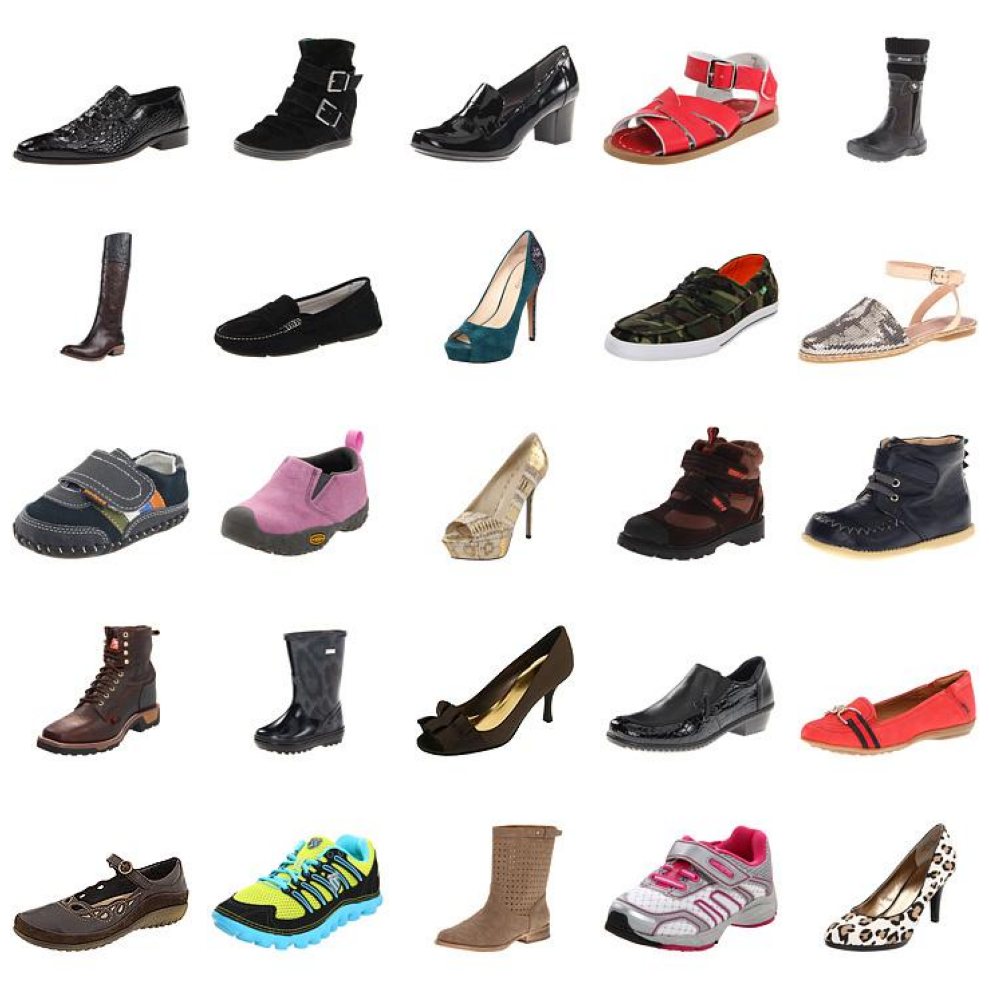

In [13]:
# Ajustar el patrón de búsqueda
image_pattern = 'ut-zap50k/ut-zap50k-images-square/**/**.jpg'

# Obtener todas las rutas de las imágenes
img_paths = glob.glob(image_pattern, recursive=True)
print(f'Se tiene un total de {len(img_paths)} imágenes')

# Verificar que se encontraron imágenes
if len(img_paths) == 0:
    print("No se encontraron imágenes. Verifica el patrón de búsqueda y la ubicación de los archivos.")
else:
    # Seleccionar 25 imágenes aleatorias
    np.random.seed(42)
    random_idx = np.random.randint(low=0, high=len(img_paths), size=25)

    # Visualizar las imágenes seleccionadas
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.flatten()
    for i, idx in enumerate(random_idx):
        img_path = img_paths[idx]
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


#Carga y Normalización de Imágenes desde el Directorio UT Zappos50K

In [5]:

def load_images(image_dir, target_size=(64, 64)):
    images = []
    for filepath in glob.glob(os.path.join(image_dir, '**/*.jpg'), recursive=True):
        img = load_img(filepath, target_size=target_size)
        img = img_to_array(img)
        img = (img - 127.5) / 127.5  # Normalizar las imágenes a [-1, 1]
        images.append(img)
    return np.array(images)

image_dir = 'ut-zap50k/ut-zap50k-images-square'
images = load_images(image_dir)
print(f'Se tiene un total de {images.shape[0]} imágenes')


Se tiene un total de 50066 imágenes


# Construcción del Generador para una Red Adversaria Generativa (GAN)

In [6]:
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(8 * 8 * 256, activation="relu", input_dim=latent_dim))
    model.add(Reshape((8, 8, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh'))
    model.summary()
    return model

latent_dim = 100
generator = build_generator(latent_dim)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       524416    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 64)        1

El modelo del generador para la Red Adversaria Generativa (GAN) está diseñado para tomar un vector latente de baja dimensión y producir imágenes sintéticas a través de una serie de capas densas y convolucionales transpuestas. Aquí se proporciona un resumen detallado de la arquitectura del generador basado en la imagen proporcionada.

El generador está bien estructurado para transformar un vector latente de baja dimensión en una imagen de alta resolución mediante una combinación de capas densas y convolucionales transpuestas. La inclusión de capas de normalización por lotes y activaciones LeakyReLU en puntos clave ayuda a mejorar la calidad de las imágenes generadas y la estabilidad del entrenamiento. Esta arquitectura es comúnmente utilizada en aplicaciones de generación de imágenes y ha demostrado ser efectiva en producir imágenes realistas a partir de ruido aleatorio.

# Construcción y Compilación del Discriminador para una Red Adversaria Generativa (GAN)



In [7]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

img_shape = (64, 64, 3)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)        


# Construcción y Compilación del Modelo GAN

In [8]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    img = generator(gan_input)
    gan_output = discriminator(img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

gan = build_gan(generator, discriminator)


# Entrenamiento de la Red Adversaria Generativa (GAN) y Muestreo de Imágenes Generadas

1/1 [==============================] - 0s 162ms/step
0 [D loss: 0.015643379651010036, acc.: 100.0%] [G loss: 0.0007594406488351524]
1/1 [==============================] - 0s 140ms/step


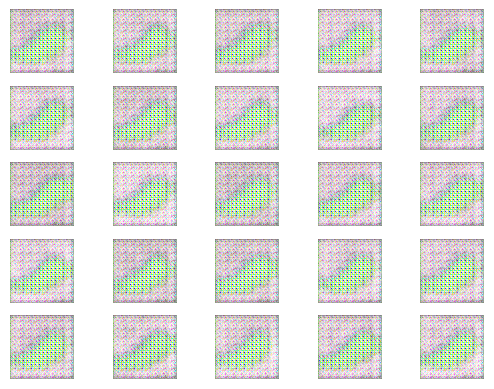

1/1 [==============================] - 0s 164ms/step
1 [D loss: 0.00040106711094267666, acc.: 100.0%] [G loss: 0.0030860817059874535]
1/1 [==============================] - 0s 162ms/step
2 [D loss: 0.00028871856920886785, acc.: 100.0%] [G loss: 0.005783763714134693]
1/1 [==============================] - 0s 167ms/step
3 [D loss: 0.00017272390323341824, acc.: 100.0%] [G loss: 0.0028904592618346214]
1/1 [==============================] - 0s 252ms/step
4 [D loss: 0.0006819292320869863, acc.: 100.0%] [G loss: 0.0013817721046507359]
1/1 [==============================] - 0s 182ms/step
5 [D loss: 0.000503293726069387, acc.: 100.0%] [G loss: 0.0018304234836250544]
1/1 [==============================] - 0s 184ms/step
6 [D loss: 0.0004988324944861233, acc.: 100.0%] [G loss: 0.0011498156236484647]
1/1 [==============================] - 0s 184ms/step
7 [D loss: 0.0007069706334732473, acc.: 100.0%] [G loss: 0.0012822926510125399]
1/1 [==============================] - 0s 179ms/step
8 [D loss: 0.00

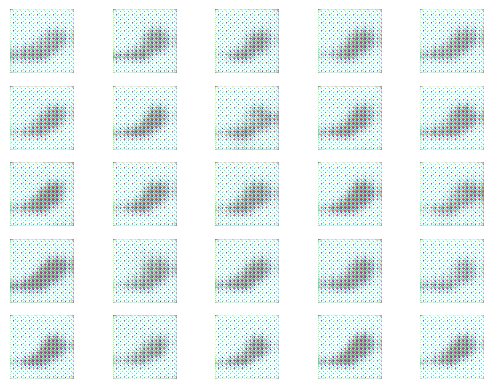

1/1 [==============================] - 0s 171ms/step
51 [D loss: 0.005181320011615753, acc.: 100.0%] [G loss: 4.2113446397706866e-05]
1/1 [==============================] - 0s 165ms/step
52 [D loss: 0.007151569006964564, acc.: 100.0%] [G loss: 2.404470433248207e-05]
1/1 [==============================] - 0s 164ms/step
53 [D loss: 0.0033275465248152614, acc.: 100.0%] [G loss: 4.570894088828936e-05]
1/1 [==============================] - 0s 158ms/step
54 [D loss: 0.013977576745674014, acc.: 100.0%] [G loss: 0.000113522561150603]
1/1 [==============================] - 0s 260ms/step
55 [D loss: 0.007140398258343339, acc.: 100.0%] [G loss: 0.00011553886724868789]
1/1 [==============================] - 0s 166ms/step
56 [D loss: 0.0053769610822200775, acc.: 100.0%] [G loss: 0.00010376876161899418]
1/1 [==============================] - 0s 158ms/step
57 [D loss: 0.0033884579315781593, acc.: 100.0%] [G loss: 0.00010196141374763101]
1/1 [==============================] - 0s 170ms/step
58 [D loss

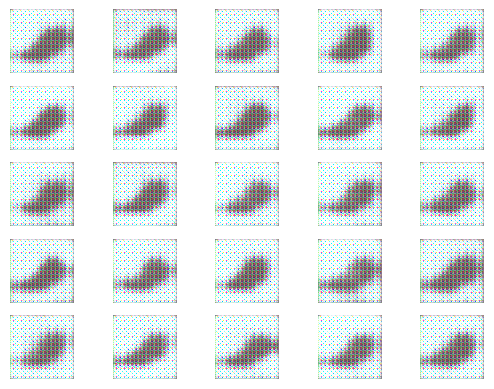

1/1 [==============================] - 0s 296ms/step
101 [D loss: 0.004099324345588684, acc.: 100.0%] [G loss: 0.003781675361096859]
1/1 [==============================] - 0s 177ms/step
102 [D loss: 0.004186226171441376, acc.: 100.0%] [G loss: 0.00379312876611948]
1/1 [==============================] - 0s 161ms/step
103 [D loss: 0.00853802787605673, acc.: 100.0%] [G loss: 0.0031115966849029064]
1/1 [==============================] - 0s 172ms/step
104 [D loss: 0.0033682730863802135, acc.: 100.0%] [G loss: 0.0067092739045619965]
1/1 [==============================] - 0s 171ms/step
105 [D loss: 0.002474387307302095, acc.: 100.0%] [G loss: 0.004058202728629112]
1/1 [==============================] - 0s 268ms/step
106 [D loss: 0.005832446739077568, acc.: 100.0%] [G loss: 0.00439110491424799]
1/1 [==============================] - 0s 198ms/step
107 [D loss: 0.002750819840002805, acc.: 100.0%] [G loss: 0.00545348459854722]
1/1 [==============================] - 0s 170ms/step
108 [D loss: 0.00

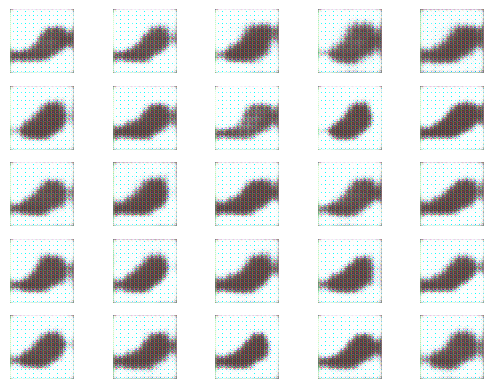

1/1 [==============================] - 0s 179ms/step
151 [D loss: 0.00500636687502265, acc.: 100.0%] [G loss: 0.0294205155223608]
1/1 [==============================] - 0s 267ms/step
152 [D loss: 0.0026362997014075518, acc.: 100.0%] [G loss: 0.021527865901589394]
1/1 [==============================] - 0s 159ms/step
153 [D loss: 0.004399592522531748, acc.: 100.0%] [G loss: 0.013061689212918282]
1/1 [==============================] - 0s 164ms/step
154 [D loss: 0.006367429858073592, acc.: 100.0%] [G loss: 0.018149439245462418]
1/1 [==============================] - 0s 165ms/step
155 [D loss: 0.010947059374302626, acc.: 100.0%] [G loss: 0.026036681607365608]
1/1 [==============================] - 0s 167ms/step
156 [D loss: 0.007499719969928265, acc.: 100.0%] [G loss: 0.02468280866742134]
1/1 [==============================] - 0s 173ms/step
157 [D loss: 0.005016712937504053, acc.: 100.0%] [G loss: 0.02698691561818123]
1/1 [==============================] - 0s 261ms/step
158 [D loss: 0.00739

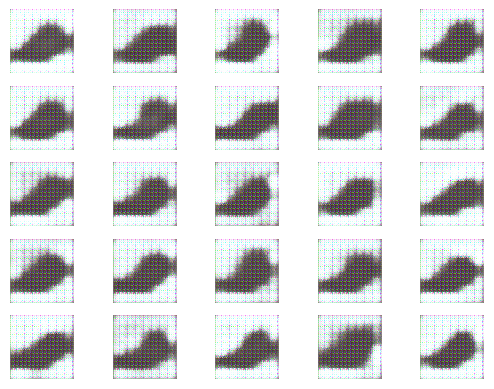

1/1 [==============================] - 0s 188ms/step
201 [D loss: 0.009708449244499207, acc.: 100.0%] [G loss: 0.01982392929494381]
1/1 [==============================] - 0s 176ms/step
202 [D loss: 0.011129321064800024, acc.: 100.0%] [G loss: 0.017278242856264114]
1/1 [==============================] - 0s 258ms/step
203 [D loss: 0.018260653130710125, acc.: 100.0%] [G loss: 0.017211847007274628]
1/1 [==============================] - 0s 163ms/step
204 [D loss: 0.007695639505982399, acc.: 100.0%] [G loss: 0.018554911017417908]
1/1 [==============================] - 0s 156ms/step
205 [D loss: 0.011086408514529467, acc.: 100.0%] [G loss: 0.015222052112221718]
1/1 [==============================] - 0s 154ms/step
206 [D loss: 0.008638296741992235, acc.: 100.0%] [G loss: 0.014853601343929768]
1/1 [==============================] - 0s 157ms/step
207 [D loss: 0.008070905692875385, acc.: 100.0%] [G loss: 0.014763559214770794]
1/1 [==============================] - 0s 187ms/step
208 [D loss: 0.01

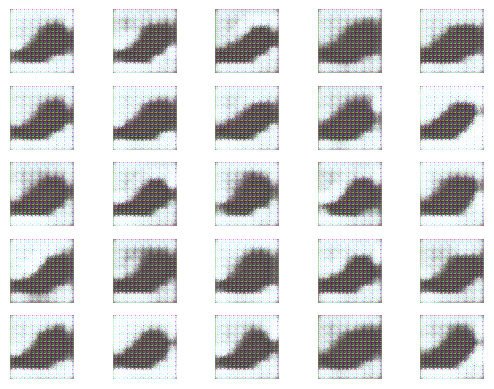

1/1 [==============================] - 0s 198ms/step
251 [D loss: 0.003757959231734276, acc.: 100.0%] [G loss: 0.011308172717690468]
1/1 [==============================] - 0s 178ms/step
252 [D loss: 0.0054716578451916575, acc.: 100.0%] [G loss: 0.016965951770544052]
1/1 [==============================] - 0s 173ms/step
253 [D loss: 0.004575661849230528, acc.: 100.0%] [G loss: 0.013606810010969639]
1/1 [==============================] - 0s 248ms/step
254 [D loss: 0.002807011012919247, acc.: 100.0%] [G loss: 0.013961276970803738]
1/1 [==============================] - 0s 163ms/step
255 [D loss: 0.005089387763291597, acc.: 100.0%] [G loss: 0.0173887200653553]
1/1 [==============================] - 0s 176ms/step
256 [D loss: 0.002711328328587115, acc.: 100.0%] [G loss: 0.013008305802941322]
1/1 [==============================] - 0s 166ms/step
257 [D loss: 0.004328678245656192, acc.: 100.0%] [G loss: 0.013822132721543312]
1/1 [==============================] - 0s 158ms/step
258 [D loss: 0.00

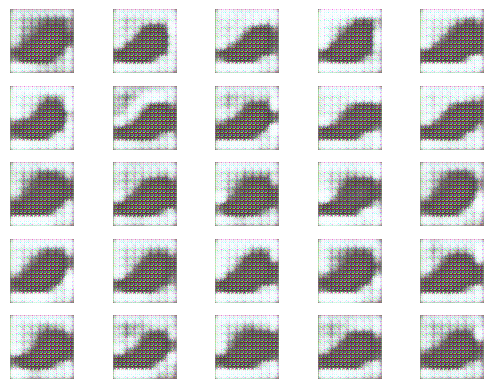

1/1 [==============================] - 0s 197ms/step
301 [D loss: 0.002703100210055709, acc.: 100.0%] [G loss: 0.007963288575410843]
1/1 [==============================] - 0s 175ms/step
302 [D loss: 0.0022103445371612906, acc.: 100.0%] [G loss: 0.00936562567949295]
1/1 [==============================] - 0s 173ms/step
303 [D loss: 0.0021928142523393035, acc.: 100.0%] [G loss: 0.00662886630743742]
1/1 [==============================] - 0s 164ms/step
304 [D loss: 0.002984975464642048, acc.: 100.0%] [G loss: 0.00641782209277153]
1/1 [==============================] - 0s 170ms/step
305 [D loss: 0.0021331151365302503, acc.: 100.0%] [G loss: 0.005703178234398365]
1/1 [==============================] - 0s 261ms/step
306 [D loss: 0.0016658322419971228, acc.: 100.0%] [G loss: 0.006509800907224417]
1/1 [==============================] - 0s 174ms/step
307 [D loss: 0.008355882251635194, acc.: 100.0%] [G loss: 0.006033739540725946]
1/1 [==============================] - 0s 175ms/step
308 [D loss: 0.

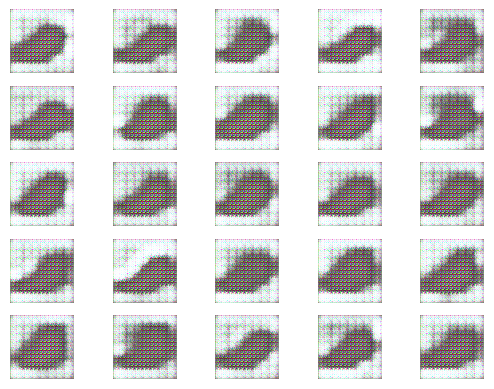

1/1 [==============================] - 0s 293ms/step
351 [D loss: 0.0009620453784009442, acc.: 100.0%] [G loss: 0.004017776809632778]
1/1 [==============================] - 0s 161ms/step
352 [D loss: 0.0015561088221147656, acc.: 100.0%] [G loss: 0.00425706896930933]
1/1 [==============================] - 0s 173ms/step
353 [D loss: 0.0011812389711849391, acc.: 100.0%] [G loss: 0.004439403768628836]
1/1 [==============================] - 0s 157ms/step
354 [D loss: 0.001587345963343978, acc.: 100.0%] [G loss: 0.005041670985519886]
1/1 [==============================] - 0s 154ms/step
355 [D loss: 0.001293213528697379, acc.: 100.0%] [G loss: 0.004081299062818289]
1/1 [==============================] - 0s 159ms/step
356 [D loss: 0.003247103886678815, acc.: 100.0%] [G loss: 0.004215106833726168]
1/1 [==============================] - 0s 255ms/step
357 [D loss: 0.0009367304155603051, acc.: 100.0%] [G loss: 0.0035819923505187035]
1/1 [==============================] - 0s 166ms/step
358 [D loss:

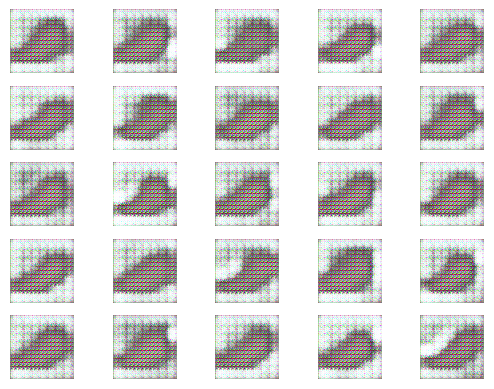

1/1 [==============================] - 0s 197ms/step
401 [D loss: 0.0016978327184915543, acc.: 100.0%] [G loss: 0.003970715217292309]
1/1 [==============================] - 0s 243ms/step
402 [D loss: 0.0009480433654971421, acc.: 100.0%] [G loss: 0.004104264546185732]
1/1 [==============================] - 0s 166ms/step
403 [D loss: 0.000931071161176078, acc.: 100.0%] [G loss: 0.005185904912650585]
1/1 [==============================] - 0s 163ms/step
404 [D loss: 0.0011685425561154261, acc.: 100.0%] [G loss: 0.004791073501110077]
1/1 [==============================] - 0s 163ms/step
405 [D loss: 0.0008589261124143377, acc.: 100.0%] [G loss: 0.005749501287937164]
1/1 [==============================] - 0s 157ms/step
406 [D loss: 0.0011014110350515693, acc.: 100.0%] [G loss: 0.005396852269768715]
1/1 [==============================] - 0s 159ms/step
407 [D loss: 0.0008460730314254761, acc.: 100.0%] [G loss: 0.0057437182404100895]
1/1 [==============================] - 0s 274ms/step
408 [D lo

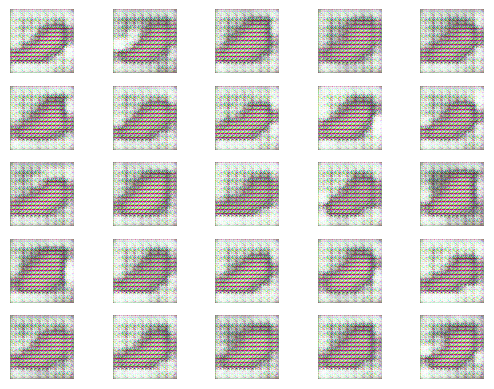

1/1 [==============================] - 0s 183ms/step
451 [D loss: 0.0015204898663796484, acc.: 100.0%] [G loss: 0.032378919422626495]
1/1 [==============================] - 0s 164ms/step
452 [D loss: 0.00268351350678131, acc.: 100.0%] [G loss: 0.03696143627166748]
1/1 [==============================] - 0s 287ms/step
453 [D loss: 0.0037271635374054313, acc.: 100.0%] [G loss: 0.027534959837794304]
1/1 [==============================] - 0s 175ms/step
454 [D loss: 0.003208770649507642, acc.: 100.0%] [G loss: 0.035175956785678864]
1/1 [==============================] - 0s 173ms/step
455 [D loss: 0.003536242409609258, acc.: 100.0%] [G loss: 0.03255143016576767]
1/1 [==============================] - 0s 158ms/step
456 [D loss: 0.003092145547270775, acc.: 100.0%] [G loss: 0.04173541069030762]
1/1 [==============================] - 0s 174ms/step
457 [D loss: 0.0030661384807899594, acc.: 100.0%] [G loss: 0.03592238575220108]
1/1 [==============================] - 0s 184ms/step
458 [D loss: 0.002

In [11]:
def train_gan(generator, discriminator, gan, images, latent_dim, epochs=10000, batch_size=64, sample_interval=1000):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Entrenar el discriminador con imágenes reales
        idx = np.random.randint(0, images.shape[0], half_batch)
        real_imgs = images[idx]
        real_labels = np.ones((half_batch, 1))

        # Entrenar el discriminador con imágenes generadas
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entrenar el generador
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Mostrar el progreso
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

        # Guardar algunas imágenes generadas
        if epoch % sample_interval == 0:
            sample_images(generator, epoch, latent_dim)

def sample_images(generator, epoch, latent_dim, num_samples=25):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    gen_imgs = generator.predict(noise)

    # Reescalar las imágenes de [-1, 1] a [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

train_gan(generator, discriminator, gan, images, latent_dim, epochs=500, batch_size=64, sample_interval=50)

 Implementa la función de entrenamiento para una Red Adversaria Generativa (GAN), junto con una función para muestrear y visualizar imágenes generadas a intervalos específicos durante el entrenamiento. El objetivo del entrenamiento es mejorar la capacidad del generador para producir imágenes que el discriminador no pueda distinguir de las imágenes reales.
 ### Resultados del Entrenamiento de la GAN

La imagen muestra un conjunto de imágenes generadas por el modelo de la Red Adversaria Generativa (GAN) después de un intervalo de muestreo durante el proceso de entrenamiento.

#### Análisis de los Resultados

1. **Calidad de las Imágenes Generadas**:
   - Las imágenes generadas parecen ser similares entre sí, lo que sugiere que el generador ha aprendido algunas características básicas del conjunto de datos de entrenamiento.
   - Sin embargo, las imágenes aún presentan un nivel significativo de ruido y falta de claridad, lo cual indica que el modelo podría beneficiarse de más épocas de entrenamiento o ajustes en los hiperparámetros.

2. **Progreso del Entrenamiento**:
   - El hecho de que las imágenes tengan una forma similar a la de los zapatos indica que el generador está comenzando a capturar la estructura básica de los objetos en el conjunto de datos.
   - La presencia de patrones repetitivos y ruido sugiere que el modelo aún está en las etapas iniciales de aprendizaje y necesita mejorar su capacidad para generar detalles más finos.

#### Próximos Pasos

Para mejorar la calidad de las imágenes generadas, se pueden considerar las siguientes acciones:

1. **Aumentar el Número de Épocas**:
   - Continuar entrenando el modelo durante más épocas para permitir que el generador y el discriminador mejoren su capacidad para producir y diferenciar imágenes realistas.

2. **Ajustar los Hiperparámetros**:
   - Revisar y ajustar los hiperparámetros como la tasa de aprendizaje, el tamaño del lote, y la arquitectura de las redes del generador y el discriminador.

3. **Evaluación Continua**:
   - Seguir evaluando y visualizando las imágenes generadas a intervalos regulares para monitorear el progreso y ajustar la estrategia de entrenamiento según sea necesario.

En resumen, el generador ha comenzado a aprender las características básicas del conjunto de datos, pero aún requiere más entrenamiento y ajustes para mejorar la calidad y diversidad de las imágenes generadas.